In [140]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [141]:
import numpy as np
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import astropy.constants as c
T_MSUN = c.M_sun.value * c.G.value / c.c.value**3

In [142]:
srate = 4096*4
t_range=np.arange(-1,1,1/srate)
input = dict(model_list = [(2,2,0, 'p')],
             t_init = 0,
             segment_length = 0.2,
             srate = srate,
             ra = None, dec = None,)

In [143]:
injected = [50, 0.7]

mass = qnm_filter.Filter.mass_unit(injected[0])
omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
omega221=qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
signal220= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
signal221= np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
waveform = qnm_filter.RealData(signal220+signal221, index=t_range)

fit = qnm_filter.Network(**input)
fit.original_data['H1'] = waveform
fit.detector_alignment()
fit.compute_acfs('original_data')
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 0.1
fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()
fit.first_index()

In [150]:
template = fit.truncate_data(fit.original_data)['H1']
SNR = fit.compute_SNR(fit.original_data, template, 'H1', optimal=True)
SNR

18.20558706323246

In [145]:
fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(signal220, index=t_range)
template = fit.truncate_data(fit.pure_nr)['H1']
SNR220 = fit.compute_SNR(fit.original_data, template, 'H1', optimal=True)

In [146]:
fit.pure_nr = {}
fit.pure_nr['H1'] = qnm_filter.RealData(signal221, index=t_range)
template = fit.truncate_data(fit.pure_nr)['H1']
SNR221 = fit.compute_SNR(fit.original_data, template, 'H1', optimal=True)

In [148]:
SNR220+SNR221 - SNR

0.6514038777490008

## Likelihood ratio vs SNR

In [13]:
SNR_arr = []
likelihood220_arr = []
likelihood220221_arr = []
N = 10
injected = [50, 0.7]

for i in range(N):
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220=qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega221=qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=injected[1])[0]
    signal220= np.real(np.exp(-1j*omega220*abs(t_range)/(injected[0]*T_MSUN)))
    signal221= np.real(np.exp(-1j*omega221*abs(t_range)/(injected[0]*T_MSUN)))
    padded = qnm_filter.pad_data_for_fft(qnm_filter.RealData(0.5*signal220+0.5*signal221, index=t_range), 2,2)
    waveform = qnm_filter.RealData(padded[1], index=padded[0])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = waveform
    fit.detector_alignment()
    fit.compute_acfs('original_data')
    temp_acf = np.full(input['srate'], 0, dtype = np.double)
    temp_acf[0] = ((i+1)/N)**2
    fit.acfs['H1'] = qnm_filter.RealData(temp_acf, index = fit.acfs['H1'].index)
    fit.cholesky_decomposition()
    fit.first_index()

    template = fit.truncate_data(fit.original_data)['H1']
    SNR = fit.compute_SNR(None, template, 'H1', optimal=True)
    likelihood220_221 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p'),(2,2,1,'p')])
    likelihood220 = fit.likelihood_vs_mass_spin(injected[0], injected[1], model_list=[(2,2,0,'p')])

    SNR_arr.append(SNR)
    likelihood220_arr.append(likelihood220)
    likelihood220221_arr.append(likelihood220_221)

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

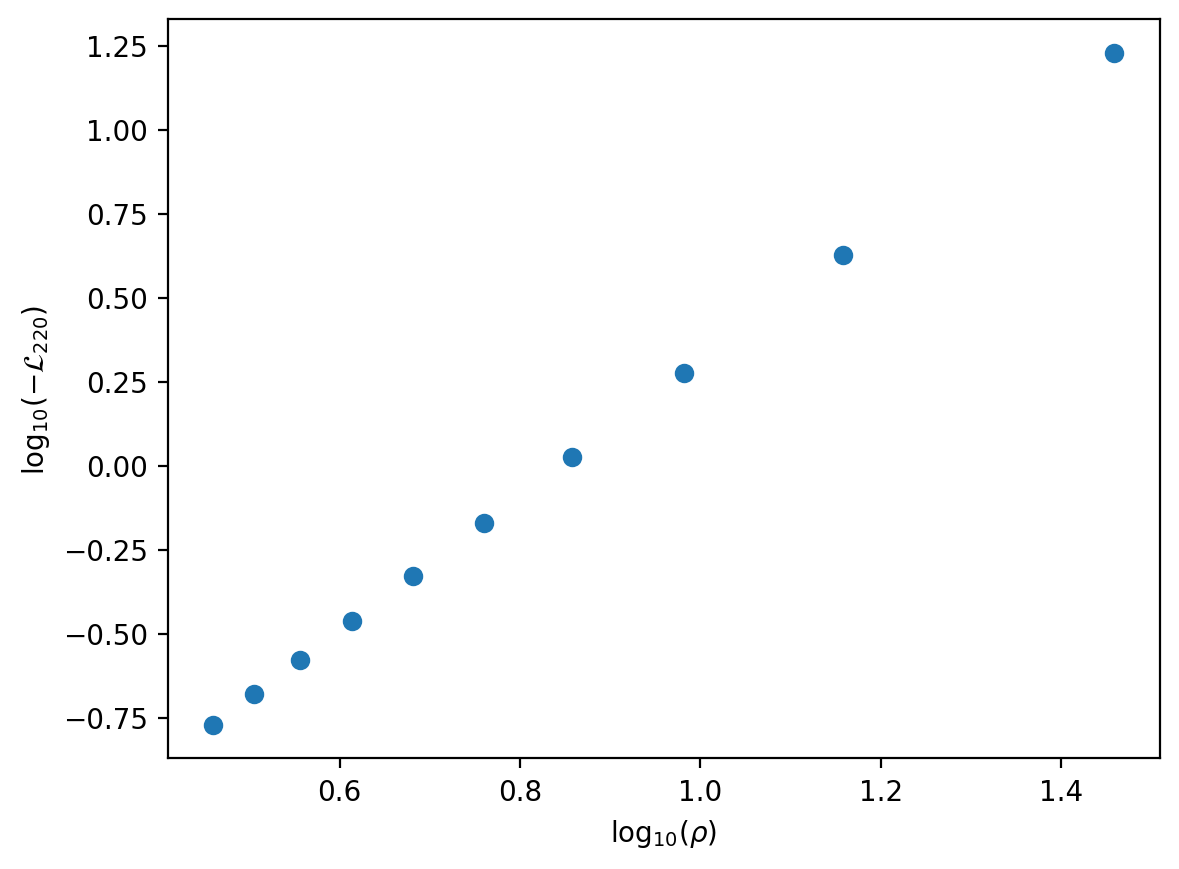

In [15]:
pl.plot(np.log10(SNR_arr), np.log10(np.multiply(-1, likelihood220_arr)), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')

Text(0, 0.5, 'log$_{10}(-\\mathcal{L}_{220}$)')

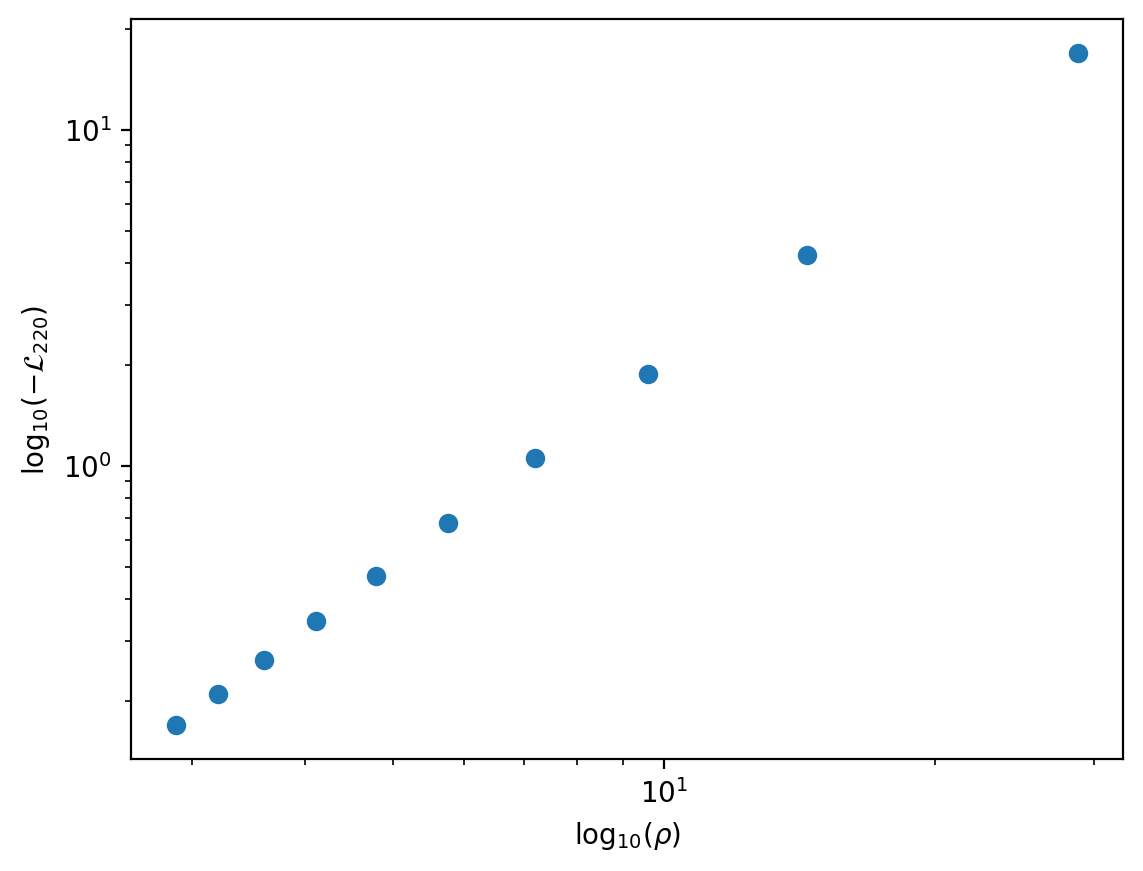

In [20]:
pl.loglog(SNR_arr, np.subtract(likelihood220221_arr,likelihood220_arr), 'o')
pl.xlabel(r'log$_{10}(\rho$)')
pl.ylabel(r'log$_{10}(-\mathcal{L}_{220}$)')
# pl.text(0.6, 2.05, 'Slope = 2')